In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.8.0


In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


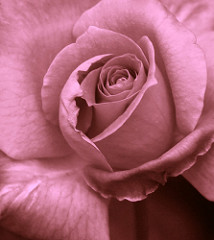

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

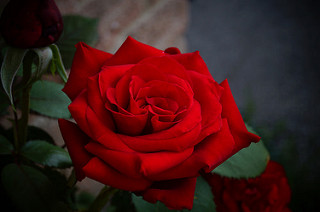

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


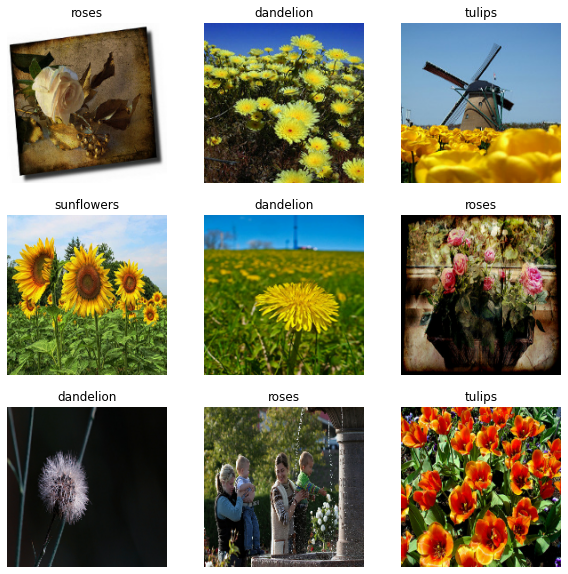

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [13]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y : (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.99638706


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [17]:
num_classes = 5

model = tf.keras.Sequential([
                             tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
                             tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
                             tf.keras.layers.MaxPooling2D(),
                             tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
                             tf.keras.layers.MaxPooling2D(),
                             tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
                             tf.keras.layers.MaxPooling2D(),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation = 'relu'),
                             tf.keras.layers.Dense(num_classes)

])

In [18]:
model.compile(
    optimizer = 'adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [19]:
model.fit(
    train_ds, 
    validation_data = val_ds,
    epochs = 3
)

Epoch 1/3
92/92 [==============================] - 168s 2s/step - loss: 1.3068 - accuracy: 0.4332 - val_loss: 1.1330 - val_accuracy: 0.5518
Epoch 2/3
92/92 [==============================] - 180s 2s/step - loss: 1.0576 - accuracy: 0.5729 - val_loss: 1.0703 - val_accuracy: 0.5531
Epoch 3/3
92/92 [==============================] - 182s 2s/step - loss: 0.8905 - accuracy: 0.6550 - val_loss: 0.9655 - val_accuracy: 0.6253


In [20]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle = False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration = False)

In [21]:
for f in list_ds.take(5):
    print(f.numpy())

b'/root/.keras/datasets/flower_photos/daisy/105806915_a9c13e2106_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/17295127995_62eff434fe_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/909277823_e6fb8cb5c8_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/15243175532_ac28c48e14_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/176284193_8fa1710431_m.jpg'


In [22]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [23]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [24]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [25]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [29]:
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels = 3)
    return tf.image.resize(img, [img_height, img_width])

In [30]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [31]:
train_ds = train_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls = AUTOTUNE)

In [32]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())    

Image shape:  (180, 180, 3)
Label:  1


In [40]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds  = configure_for_performance(val_ds )

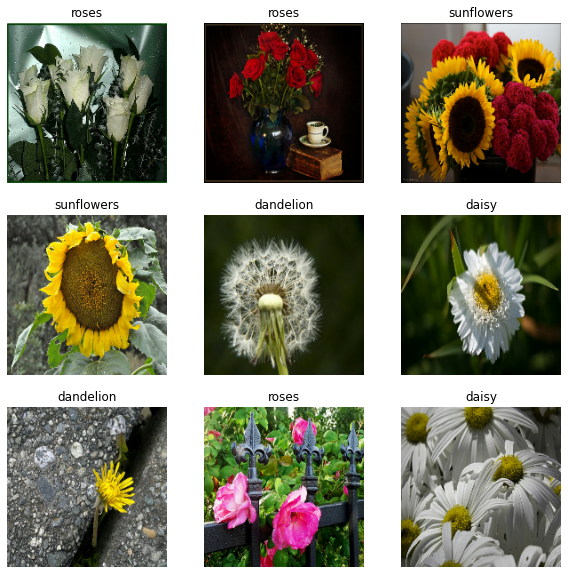

In [41]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [42]:
model.fit(train_ds, validation_data = val_ds, epochs = 3)

Epoch 1/3
23/23 [==============================] - 62s 3s/step - loss: 0.7743 - accuracy: 0.7289 - val_loss: 0.6484 - val_accuracy: 0.7398
Epoch 2/3
23/23 [==============================] - 54s 2s/step - loss: 0.5547 - accuracy: 0.7997 - val_loss: 0.4002 - val_accuracy: 0.8515
Epoch 3/3
23/23 [==============================] - 53s 2s/step - loss: 0.4300 - accuracy: 0.8569 - val_loss: 0.2875 - val_accuracy: 0.9169


TensorFlow 데이터세트 사용하기

In [43]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split = ['train[:80%]', 'train[80%:90%]','train[90%:]'],
    with_info = True, 
    as_supervised = True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [44]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


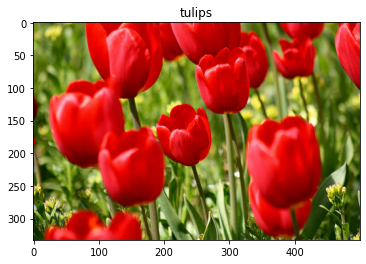

In [46]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [47]:
from tensorflow.python.framework import config
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)